## Resampling avec SMOTE (Synthetic Minority Oversampling TEchnique)

Dans ce notebook, nous allons voir une technique d'augmentation de données par rééchantillonnage : SMOTE.

Il existe plusieurs solutions pour traiter les données déséquilibrées est de les **rééquilibrer**. Ce type d’approches – appelées **data-level** solutions – se décline sous 2 formes principales :

* **Sous-échantillonnage (undersampling)** :  Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires. Cette approche permet de diminuer la redondance des informations apportées par le grand nombre d’individus majoritaires.


* **Sur-échantillonnage (oversampling)** : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation. Différentes solutions sont possibles, comme le **clonage** aléatoire ou le SMOTE.

Le sous-échantillonnage et le sur-échantillonnage peuvent être combinés pour corriger le déséquilibre plus efficacement.

Nous allons étudier SMOTE

### S.M.O.T.E

Le **SMOTE**, acronyme pour **Synthetic Minority Oversampling TEchnique**, est une méthode de **suréchantillonnage des observations minoritaires**. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.

C’est sur ces données transformées, auxquelles on a ajouté de faux individus synthétiques, que l’on va ensuite entraîner un modèle de Machine Learning.

Il faut savoir que pour générer de nouvelles données, les techniques qui se basent sur SMOTE doivent calculer des moyennes de distances pour **clusteriser** les données en différentes catégories, il faut donc faire attention à bien avoir des features numériques si l'on traite des features catégorielles (nous verrons plus tard ce mélange de variables **Numériques-Catégorielles** qui est un SMOTE particulier : le **SMOTE-NC**)

#### Fonctionnement de SMOTE (avec KNN) : Creer des observations synthétiques

Pour créer un individu synthétique, voici les étapes de l’algorithme du SMOTE :

1. On sélectionne aléatoirement un sample d'observation minoritaire initiale.
2. On Identifie ses KNN(k plus proches voisins) parmi les observations minoritaires (où k est un paramètre défini par l’utilisateur).
3. On choisit aléatoirement l’un des k plus proches voisins.
4. On génère aléatoirement un coefficient $0<\alpha<1$.
5. On crée un nouvel individu entre l’observation initiale et le plus proche voisin choisi, selon la valeur du coefficient . Par exemple, si $\alpha = 0.5$, le nouvel individu sera positionné à mi-chemin entre l’observation initiale et le plus proche voisin choisi.


Ces étapes sont répétées jusqu’à ce que le nombre d’individus générés atteigne une valeur définie par l’utilisateur.

Il existe deux paramètres qu'il faut configurer pour SMOTE :

* **k_neighbors (k)** : le nombre de plus proches voisins (nearest neighbors) candidats pour la création d’un nouvel individu. Ce paramètre a un effet sur la distribution des individus synthétiques dans l’espace, et donc sur la performance du modèle qui sera entraîné après le SMOTE. Sa valeur optimale dépend de la structure des données. Attention ! Si les individus minoritaires originaux sont répartis sous forme de groupes de taille inférieure à $n$ individus et que l’on utilise $k > n$, les individus générés risquent d’être positionnés entre les groupes de minoritaires réels. Ils ne sont alors pas représentatifs des données réelles et risquent de diminuer les performances du modèle.

* **sampling_strategy ($\alpha_{os}$ ou le nombre d’observations synthétiques)** à générer : Ce paramètre est exprimé sous la forme d’un taux d’observations minoritaires à atteindre, noté $\alpha_{os}$ (os pour “oversampling“). Plus le ratio est élevé par rapport au ratio initial de vos données, plus l’algorithme devra produire d’individus synthétiques et plus son temps de calcul sera long.

Le problème majeur des classes déséquilibrées est l'**Overfitting** : Il faut voir les points de données comme une repartition de distribution dans l'espace (espace à p-dimensions représenté par p features). Le modèle prédit uniformément une probabilité très faible sur la majorité de l’espace, à l’exception de quelques zones très réduites, celles où sont situées les données du train. Ces zones sont trop restreintes pour permettre de bien prédire les données du test, qui sont souvent situées juste à côté, mais dans une zone de faible probabilité. Le modèle a donc une bonne performance sur train, mais médiocre sur test : il a surappris les données et a une forte variance (cette forte variance lui empèche de pouvoir généraliser au données du test car le modèle est devenu trop complexe..il faudrait augmenter le biais pour réduire la variance, ce qui peut se faire en augmentant le nombre de samples de la classe minoritaire). 

En utilisant des techniques de rééchantillonnage (qui est du rééquilibrage de classe), lees zones de forte probabilité prédites dans l'espace à p-dimensions par le modèle sont à présent plus larges (car il y a mécaniquement plus de samples de classe minoritaire dans le même espace) et permettent de couvrir l’espace dans lequel se trouvent les données du test. Ainsi un point de donnée de classe minoritaire se voit attribuer une probabilité plus élevée de repartition dans l'espace du test, alors qu’il était dans une zone de probabilité faible sans rééquilibrage. Le modèle a une performance similaire sur le train et le test : il a **réduit sa variance en augmentant son biais** (cad qu'en occupant plus d'espace, le modèle perd en compléxité).

Etudions comment fonctionne SMOTE en détail

In [24]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
#df = pd.read_csv('./src/conversion_data_train.csv')
df = pd.read_csv('conversion_data_train.csv')
df.shape

(284580, 6)

In [3]:
categ_str_features = ['country', 'source']
categ_int_features = ['new_user']
numeric_features = ['age', 'total_pages_visited']
target = 'converted'

In [4]:
X = df.iloc[:, :-1]
y = df.loc[:, 'converted']

### 1. Deal with Unbalanced Data : SMOTE

On va utiliser SMOTE pour faire du resampling mais il faut faire attention aux variables categorielles : nous avons le choix entre SMOTETOmek et SMOTE-NC

On commence par OneHotEncoded les variables categorielles

In [5]:
onehot = OneHotEncoder(drop='first')
X = onehot.fit_transform(X)

In [ ]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html
# https://kobia.fr/imbalanced-data-smote-nc/
# SMOTE-NC permet de traiter des variables categorielles (avec des one hot encoded)

In [15]:
print(f"Il y a {int(y.value_counts()[0] / y.value_counts()[1])}x plus de non abonnés que d'abonnés, cad {round(y.value_counts()[1] / y.value_counts()[0],2)} % en taux de classe minoritaire") 

Il y a 30x plus de non abonnés que d'abonnés, cad 0.03 % en taux de classe minoritaire


On va commencer par utiliser SMOTE (car il existe plusieurs variantes : SMOTETomek, SMOTE-NC que nous detaillerons par la suite).

Pour le choix des valeurs des paramètres, nous allons prendre un `k_neighbors`(**nombre de voisins(KNN))** de **3** : l'algorithme **K-nearest neighbors** se base sur un calcul de distance (Euclidienne(la droite entre deux points) ou Manhattan(deplacement en angle droit entre deux points). Pour un problème de classification (fonctionne aussi pour des problèmes de regression, et dans ce cas, on fait la moyenne des valeurs des voisins), nous allons prendre la classe majoritaire des voisins les plus proches. En ce qui concerne `sampling_strategy`, nous definissons un taux de samples synthétique de 50% par rapport au nombre de la classe majoritaire. De base, nous étions à 0.03% et nous voudrions élever cette proportion à 50%, cad élevé 16x le taux de classe minoritaire pour l'equilibrer à hauteur de 50% par rapport à la classe majoritaire) 

In [13]:
import imblearn
print("Imblearn version :",imblearn.__version__)
from imblearn.over_sampling import SMOTE

# Instanciation de SMOTE avec comme paramètres 3 KNN et 50% de taux de faux samples pour la classe minoritaire
sm = SMOTE(k_neighbors=3, sampling_strategy=0.5)

# On effectue le resample
X_resampled, y_resampled = sm.fit_resample(X, y)

Imblearn version : 0.9.1


Pour ce notebook, nous utiliserons entièrement nos test sur une **Logistic Regression**, **Decision Tree** et **Random Forest** pour comparer les différents scores.

In [14]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=0, stratify=y_res)

In [8]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']
# numeric_features = ['total_pages_visited']
# categ_features = ['new_user']

num_transf = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler())
)

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features)
)

In [33]:
lr = LogisticRegression(solver='saga', max_iter=1000)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

lr.fit(X_train_resampled, y_train_resampled)
dt.fit(X_train_resampled, y_train_resampled)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [36]:
params_lr = {
    'C' : [1.025, 1.027, 1.029, 1.031, 1.032,1.034],
    'penalty' : ['l1','l2']
}

params_dt ={
    'max_depth':[10, 11, 12, 13, 14],
    'min_samples_split':[10, 12, 14,18,22],
    'min_samples_leaf':[3, 4, 5, 6]
}

params_rf = {
    'max_depth':[7, 8, 9, 10, 11, 12],
    'min_samples_split':[7, 8, 9, 10, 11, 12],
    'n_estimators':[20, 30, 40, 50, 60]
}

### Logsitic Regression

In [35]:
gridsearch_lr_resampled = GridSearchCV(lr, param_grid = params_lr, cv=10)
gridsearch_lr_resampled.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': [1.025, 1.027, 1.029, 1.031, 1.032, 1.034],
                         'penalty': ['l1', 'l2']})

In [42]:
gridsearch_lr_resampled.best_params_

{'C': 1.027, 'penalty': 'l1'}

In [45]:
log_reg_resampled = gridsearch_lr_resampled.best_estimator_

In [47]:
y_train_pred_lr_resampled = log_reg.predict(X_train_resampled)
y_test_pred_lr_resampled = log_reg.predict(X_test_resampled)

In [48]:
print(f"f1_score sur le train set :{f1_score(y_train_resampled, y_train_pred_lr_resampled)}")
print(f"f1_score sur le test set :{f1_score(y_test_resampled, y_test_pred_lr_resampled)}")

f1_score sur le train set :0.9277460491819458
f1_score sur le test set :0.9280886857587396


In [49]:
scores_train_lr_resampled = cross_val_score(log_reg_resampled, X_train_resampled, y_train_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le train set :{scores_train_lr_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le train set :{scores_train_lr_resampled.std()}")

Moyenne des f1_scores pour le train set :0.9275681867956775
Ecart-type des f1_scores pour le train set :0.0014190960629014077


In [50]:
scores_test_lr_resampled = cross_val_score(log_reg_resampled, X_test_resampled, y_test_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le test set :{scores_test_lr_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le test set :{scores_test_lr_resampled.std()}")

Moyenne des f1_scores pour le test set :0.9267686314342592
Ecart-type des f1_scores pour le test set :0.0038782478941427087


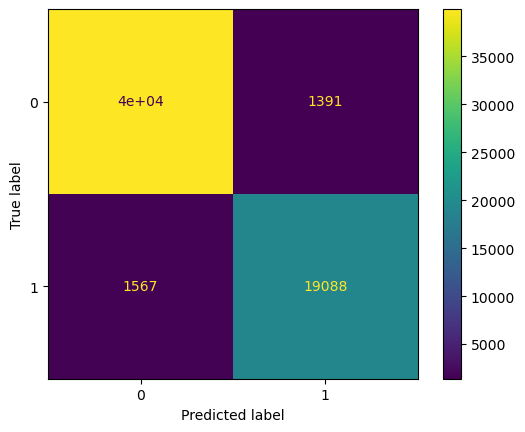

In [63]:
ConfusionMatrixDisplay.from_estimator(log_reg_resampled, X_test_resampled, y_test_resampled);

### Decision Tree

In [37]:
gridsearch_dt_resampled = GridSearchCV(dt, param_grid = params_dt, cv=10)
gridsearch_dt_resampled.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'min_samples_split': [10, 12, 14, 18, 22]})

In [43]:
gridsearch_dt_resampled.best_params_

{'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [52]:
dec_tree_resampled = gridsearch_dt_resampled.best_estimator_

In [53]:
y_train_pred_dt_resampled = dec_tree_resampled.predict(X_train_resampled)
y_test_pred_dt_resampled = dec_tree_resampled.predict(X_test_resampled)

In [54]:
print(f"f1_score sur le train set :{f1_score(y_train_resampled, y_train_pred_dt_resampled)}")
print(f"f1_score sur le test set :{f1_score(y_test_resampled, y_test_pred_dt_resampled)}")

f1_score sur le train set :0.8938396193800109
f1_score sur le test set :0.8910133843212237


In [55]:
scores_train_dt_resampled = cross_val_score(dec_tree_resampled, X_train_resampled, y_train_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le train set :{scores_train_dt_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le train set :{scores_train_dt_resampled.std()}")

Moyenne des f1_scores pour le train set :0.8936049406987591
Ecart-type des f1_scores pour le train set :0.0021585300476389207


In [56]:
scores_test_dt_resampled = cross_val_score(dec_tree_resampled, X_test_resampled, y_test_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le test set :{scores_test_dt_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le test set :{scores_test_dt_resampled.std()}")

Moyenne des f1_scores pour le test set :0.8856325237693732
Ecart-type des f1_scores pour le test set :0.003689706576811362


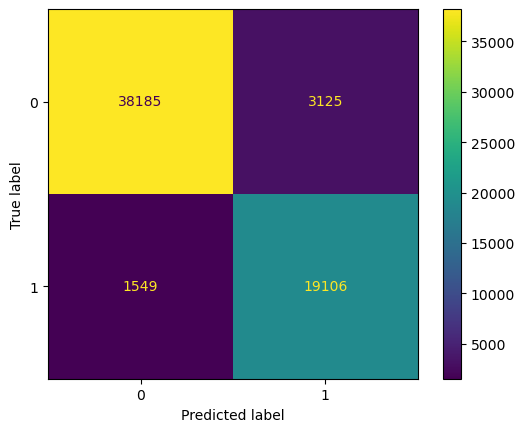

In [62]:
ConfusionMatrixDisplay.from_estimator(dec_tree_resampled, X_test_resampled, y_test_resampled);

### Random Forest

In [38]:
gridsearch_rf_resampled = GridSearchCV(rf, param_grid = params_rf, cv=10)
gridsearch_rf_resampled.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12],
                         'min_samples_split': [7, 8, 9, 10, 11, 12],
                         'n_estimators': [20, 30, 40, 50, 60]})

In [44]:
gridsearch_rf_resampled.best_params_

{'max_depth': 12, 'min_samples_split': 9, 'n_estimators': 50}

In [58]:
ran_for_resampled = gridsearch_rf_resampled.best_estimator_

In [59]:
y_train_pred_rf_resampled = ran_for_resampled.predict(X_train_resampled)
y_test_pred_rf_resampled = ran_for_resampled.predict(X_test_resampled)

In [60]:
print(f"f1_score sur le train set :{f1_score(y_train_resampled, y_train_pred_rf_resampled)}")
print(f"f1_score sur le test set :{f1_score(y_test_resampled, y_test_pred_rf_resampled)}")

f1_score sur le train set :0.9018240660354632
f1_score sur le test set :0.8984556582821136


In [61]:
scores_train_rf_resampled = cross_val_score(ran_for_resampled, X_train_resampled, y_train_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le train set :{scores_train_rf_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le train set :{scores_train_rf_resampled.std()}")

Moyenne des f1_scores pour le train set :0.900517006393056
Ecart-type des f1_scores pour le train set :0.004413193401936689


In [64]:
scores_test_rf_resampled = cross_val_score(ran_for_resampled, X_test_resampled, y_test_resampled, scoring='f1', cv=10)
print(f"Moyenne des f1_scores pour le test set :{scores_test_rf_resampled.mean()}")
print(f"Ecart-type des f1_scores pour le test set :{scores_test_rf_resampled.std()}")

Moyenne des f1_scores pour le test set :0.9000123617276973
Ecart-type des f1_scores pour le test set :0.007259331033854059


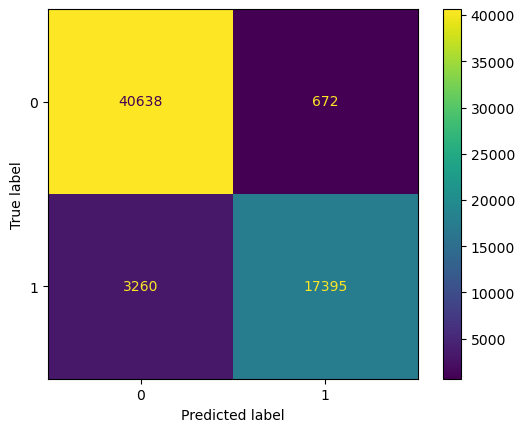

In [65]:
ConfusionMatrixDisplay.from_estimator(ran_for_resampled, X_test_resampled, y_test_resampled);

### Sauvegarde des modèles

In [41]:
import pickle

with open('./src/models/logistic_regression_model_resampled', 'wb') as f:
    pickle.dump(gridsearch_lr_resampled, f)
    
with open('./src/models/decision_tree_model_resampled', 'wb') as f:
    pickle.dump(gridsearch_dt_resampled, f)
    
with open('./src/models/random_forest_model_resampled', 'wb') as f:
    pickle.dump(gridsearch_rf_resampled, f)

### Chargement des modèles

In [16]:
import pickle

with open('./src/models/logistic_regression_model_resampled', 'rb') as f:
    gridsearch_lr_resampled = pickle.load(f)
    
with open('./src/models/decision_tree_model_resampled', 'rb') as f:
    gridsearch_dt_resampled = pickle.load(f)
    
with open('./src/models/random_forest_model_resampled', 'rb') as f:
    gridsearch_rf_resampled = pickle.load(f)

Après avoir trouver les meilleurs hyperparamètres pour les 3 modèles **Logistic Regression**, **Decision Tree** et **Random Forest**, nous allons les appliquer à 3 autres modèles mais qui s'entraineront cette fois-ci sur le dataset original (non undersampled)

In [19]:
print(f"Meilleurs hyperparamètres pour le modèle de Logistic Regression : {gridsearch_lr_resampled.best_params_}")
print(f"Meilleurs hyperparamètres pour le modèle de Decision Tree : {gridsearch_dt_resampled.best_params_}")
print(f"Meilleurs hyperparamètres pour le modèle de Random Forest : {gridsearch_rf_resampled.best_params_}")

Meilleurs hyperparamètres pour le modèle de Logistic Regression : {'C': 1.027, 'penalty': 'l1'}
Meilleurs hyperparamètres pour le modèle de Decision Tree : {'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 10}
Meilleurs hyperparamètres pour le modèle de Random Forest : {'max_depth': 12, 'min_samples_split': 9, 'n_estimators': 50}


On va créer une fonction pour repérer facilement le f1-score, la precision et le recall pour comparer les modèles

In [22]:
def model_score(model, undersamp=False):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    if undersamp:
        y_train_pred = model.predict(X_train_resampled)
        y_test_pred = model.predict(X_test_resampled)
        y_train = y_train_resampled
        y_test = y_test_resampled
    
    print("----------------------------------------\n                 Sur le Train set            \n----------------------------------------")
    print(f'Accuracy : {accuracy_score(y_train,y_train_pred)}')
    print(f'Precision : {precision_score(y_train,y_train_pred)}')
    print(f'Recall : {recall_score(y_train,y_train_pred)}')
    print("----------------------------------------\n                 Sur le Test set            \n----------------------------------------")
    print(f'Accuracy : {accuracy_score(y_test,y_test_pred)}')
    print(f'Precision : {precision_score(y_test,y_test_pred)}')
    print(f'Recall : {recall_score(y_test,y_test_pred)}')

In [23]:
model_score(gridsearch_lr_resampled, undersamp=True)

----------------------------------------
                 Sur le Train set            
----------------------------------------
Accuracy : 0.9516937929856039


NameError: name 'precision_score' is not defined

### Deal with Unbalanced Data : SMOTETomek

In [10]:
smt = SMOTETomek(random_state=42,n_jobs=-1)

X_res, y_res = smt.fit_resample(X, y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=0, stratify=y_res)

In [19]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']
# numeric_features = ['total_pages_visited']
# categ_features = ['new_user']

num_transf = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler())
)

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features)
)

### Logistic Regression

In [29]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [30]:
params = {
    'C' : [1.025, 1.027, 1.029, 1.031, 1.032,1.034],
    'penalty' : ['l1','l2']
}

gridsearch_lr = GridSearchCV(lr, param_grid = params, cv=10)
gridsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1.025, 1.027, 1.029, 1.031, 1.032, 1.034],
                         'penalty': ['l1', 'l2']})

In [31]:
print("Best hyperparameters : ", gridsearch_lr.best_params_)
print("Best R2 score : ", gridsearch_lr.best_score_)

Best hyperparameters :  {'C': 1.034, 'penalty': 'l2'}
Best R2 score :  0.9505019436968686


In [32]:
y_train_pred_lr = gridsearch_lr.predict(X_train)
y_test_pred_lr = gridsearch_lr.predict(X_test)

In [33]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.9506967185154864
f1-score sur le test set :  0.9501959266605389


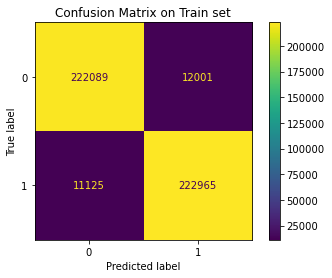

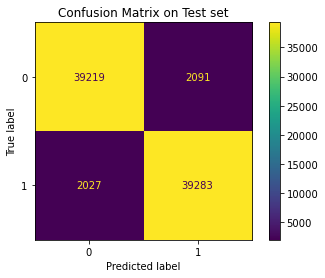

In [34]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_test, y_test, ax=ax) 
plt.show()

### XGBoost

In [7]:
xgboost = XGBClassifier()

params = {
    'max_depth': [4,5,6,7,8], 
    'min_child_weight': [3.5,4.0,5.0], 
    'n_estimators': [14,15,17,20] 
}

xgboost_gs = GridSearchCV(xgboost, param_grid = params, cv=10) 
xgboost_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [3.5, 4.0, 5.0],
                         'n_estimators': [14, 15, 17, 20]})

In [9]:
print("Best hyperparameters : ", xgboost_gs.best_params_)
print("Best R2 score : ", xgboost_gs.best_score_)

Best hyperparameters :  {'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 20}
Best R2 score :  0.9431757016532103


In [10]:
y_train_pred_lr = xgboost_gs.predict(X_train)
y_test_pred_lr = xgboost_gs.predict(X_test)

In [11]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.9441076357724678
f1-score sur le test set :  0.9427337093483739


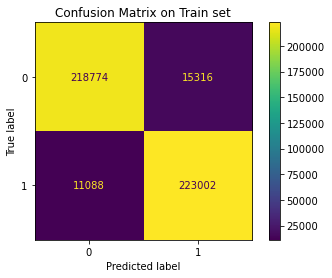

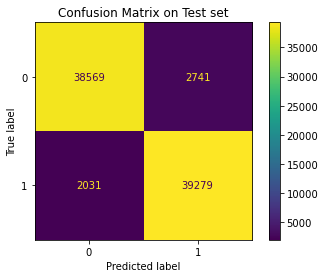

In [12]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(xgboost_gs, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(xgboost_gs, X_test, y_test, ax=ax) 
plt.show()

In [43]:
X_res_df = pd.DataFrame(X_res)

,0
0,"(0, 7)\t1.0\n (0, 62)\t1.0\n (0, 63)\t1.0\..."
1,"(0, 1)\t1.0\n (0, 6)\t1.0\n (0, 62)\t1.0\n..."
2,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 64)\t1.0\n..."
3,"(0, 2)\t1.0\n (0, 8)\t1.0\n (0, 62)\t1.0\n..."
4,"(0, 2)\t1.0\n (0, 13)\t1.0\n (0, 62)\t1.0\..."
...,...
550795,"(0, 79)\t1.0\n (0, 64)\t1.0\n (0, 8)\t1.0\..."
550796,"(0, 69)\t1.0\n (0, 64)\t0.09729176726242972..."
550797,"(0, 75)\t1.0\n (0, 64)\t1.0\n (0, 62)\t1.0..."
550798,"(0, 76)\t1.0\n (0, 6)\t1.0\n (0, 2)\t1.0"


In [54]:
X_res_df = pd.DataFrame(X_res.todense())
X_res_df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550798,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
smote_df = pd.concat([X_res_df,y_res],axis=1)

In [53]:
smote_df.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,converted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [55]:
smote_df.to_csv("./src/smote_df.csv", index=False)

### Work with SMOTE

In [3]:
df_smote = pd.read_csv("./src/smote_df.csv")
df_smote

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,converted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550798,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
X = df_smote.iloc[:,:-1]
y = df_smote['converted']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [13]:
df = pd.read_csv('conversion_data_train.csv')

X = df.iloc[:,:-1]
y = df['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [ ]:
xgboost_gs.predict(X_train)
# y_test_pred_lr = xgboost_gs.predict(X_test)